<a href="https://colab.research.google.com/github/yuvipaloozie/QM9-GNN/blob/main/QM9_GNN_2D_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Installations
!pip install torch torch-geometric
!pip install rdkit
!pip install qm9pack
!pip install py3Dmol
!pip install pandas numpy matplotlib seaborn tqdm

# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Cheminformatics & DL
import qm9pack
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import py3Dmol

  Using cached qm9pack-1.0.3-py3-none-any.whl.metadata (326 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.7/103.7 MB 2.3 MB/s eta 0:00:00


In [3]:
# Basic EDA

print("Loading data from qm9pack... ")
df = qm9pack.get_data('qm9')
print(f"Data shape: {df.shape}\n")
print("Data Head:")
display(df.head())

print("\nData Info:")
df.info()

TARGET_PROPERTY = 'HOMO_LUMO_gap_au'

original_size = len(df)
df_clean = df.dropna(subset=['SMILES', TARGET_PROPERTY])
cleaned_size = len(df_clean)

print(f"Original number of molecules: {original_size}")
print(f"Cleaned number of molecules (after dropping NaNs): {cleaned_size}")

for key in df_clean.keys():
    qm9pack.helper(key)

Loading data from qm9pack... 
Data shape: (130831, 31)

Data Head:


,XYZ_file,Index,SMILES,InChi,N_atoms,Stoichiometry,Elements,XYZ_Ang,Mulliken_pop,Harmonic_Freq_cmi,...,InternalEnergy_298K_au,Enthalphy_298K_au,GibbsFreeEnergy_298K_au,Heatcapacity_Cv_cal_mol_K,A_xx,A_xy,A_yy,A_xz,A_yz,A_zz
0,dsgdb9nsd_000001.xyz,1,C,InChI=1S/CH4/h1H4,5,"[4,1,0,0,0]","['C','H','H','H','H']","[[-0.0126981359,1.0858041578,0.0080009958],[0....","[-0.535689,0.133921,0.133922,0.133923,0.133923]","[1341.307,1341.3284,1341.365,1562.6731,1562.74...",...,-40.476062,-40.475117,-40.498597,6.469,13.211,0.0,13.211,0.0,0.0,13.211
1,dsgdb9nsd_000002.xyz,2,N,InChI=1S/H3N/h1H3,4,"[3,0,1,0,0]","['N','H','H','H']","[[-0.0404260543,1.0241077531,0.0625637998],[0....","[-0.707143,0.235712,0.235712,0.23572]","[1103.8733,1684.1158,1684.3072,3458.7145,3575....",...,-56.523026,-56.522082,-56.544961,6.316,10.439,0.0,10.438,0.0,0.0,7.504
2,dsgdb9nsd_000003.xyz,3,O,InChI=1S/H2O/h1H2,3,"[2,0,0,1,0]","['O','H','H']","[[-0.0343604951,0.9775395708,0.0076015923],[0....","[-0.589706,0.294853,0.294853]","[1671.4222,3803.6305,3907.698]",...,-76.401867,-76.400922,-76.422349,6.002,4.492,0.0,8.049,0.0,0.0,6.398
3,dsgdb9nsd_000004.xyz,4,C#C,InChI=1S/C2H2/c1-2/h1-2H,4,"[2,2,0,0,0]","['C','C','H','H']","[[0.5995394918,0.,1.],[-0.5995394918,0.,1.],[-...","[-0.207019,-0.207019,0.207019,0.207019]","[549.7648,549.7648,795.2713,795.2713,2078.1131...",...,-77.305527,-77.304583,-77.327429,8.574,10.491,0.0,10.491,0.0,0.0,27.863
4,dsgdb9nsd_000005.xyz,5,C#N,InChI=1S/CHN/c1-2/h1H,3,"[1,1,1,0,0]","['C','N','H']","[[-0.0133239314,1.1324657151,0.0082758861],[0....","[-0.049656,-0.188473,0.238128]","[799.0101,799.0101,2198.4393,3490.3686]",...,-93.409370,-93.408425,-93.431246,6.278,9.553,0.0,9.553,0.0,0.0,19.879



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130831 entries, 0 to 130830
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   XYZ_file                   130831 non-null  object 
 1   Index                      130831 non-null  int64  
 2   SMILES                     130831 non-null  object 
 3   InChi                      130831 non-null  object 
 4   N_atoms                    130831 non-null  int64  
 5   Stoichiometry              130831 non-null  object 
 6   Elements                   130831 non-null  object 
 7   XYZ_Ang                    130831 non-null  object 
 8   Mulliken_pop               130831 non-null  object 
 9   Harmonic_Freq_cmi          130831 non-null  object 
 10  RotA_GHz                   130831 non-null  float64
 11  RotB_GHz                   130831 non-null  float64
 12  RotC_GHz                   130831 non-null  float64
 13  Dipole_debye     

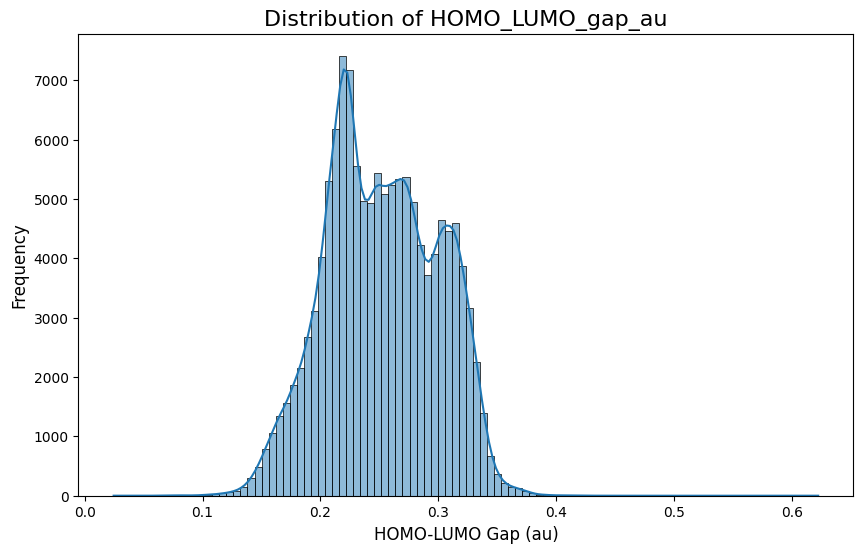

count    130831.000000
mean          0.252045
std           0.047192
min           0.024600
25%           0.217000
50%           0.250200
75%           0.289400
max           0.622100
Name: HOMO_LUMO_gap_au, dtype: float64


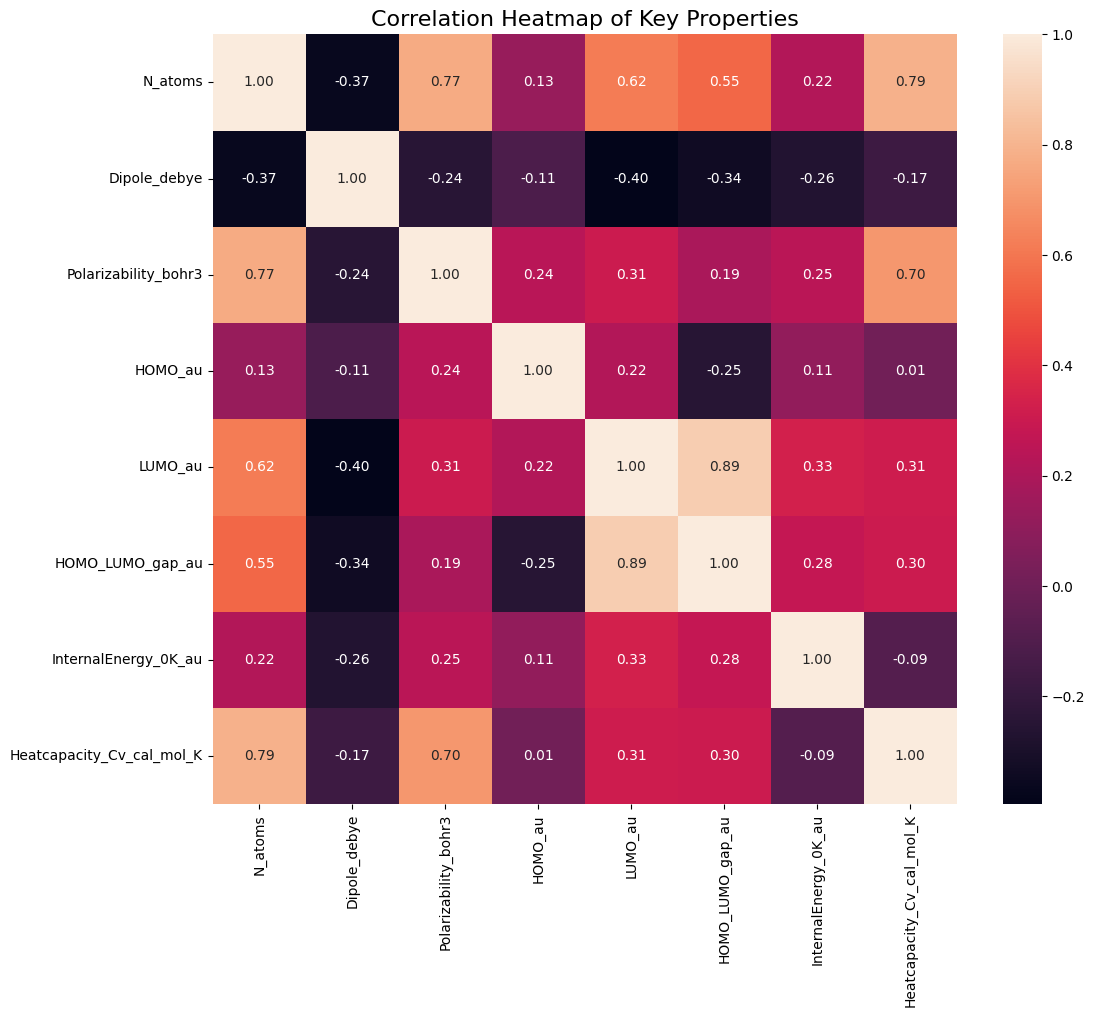

In [4]:
# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(df_clean[TARGET_PROPERTY], kde=True, bins=100)
plt.title(f'Distribution of {TARGET_PROPERTY}', fontsize=16)
plt.xlabel('HOMO-LUMO Gap (au)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Get summary statistics for the target
print(df_clean[TARGET_PROPERTY].describe())

# Select a subset of key numerical properties
numerical_cols = [
    'N_atoms', 'Dipole_debye', 'Polarizability_bohr3',
    'HOMO_au', 'LUMO_au', 'HOMO_LUMO_gap_au',
    'InternalEnergy_0K_au', 'Heatcapacity_Cv_cal_mol_K'
]

# Calculate the correlation matrix
corr_matrix = df_clean[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='rocket')
plt.title('Correlation Heatmap of Key Properties', fontsize=16)
plt.show()

--- Displaying Random Molecule (Index: 36669) ---
SMILES: C#CCCC1CC1C#N
HOMO-LUMO Gap: 0.2932 au

2D Structure:


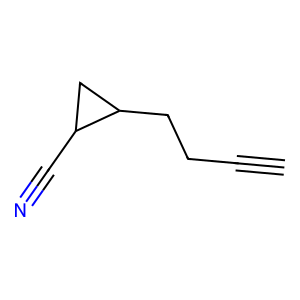


3D Interactive Structure:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [5]:
# Visualize molecules

random_row = df_clean.sample(n=1)
smiles_string = random_row['SMILES'].iloc[0]
molecule_index = random_row['Index'].iloc[0]
gap_value = random_row[TARGET_PROPERTY].iloc[0]

print(f"--- Displaying Random Molecule (Index: {molecule_index}) ---")
print(f"SMILES: {smiles_string}")
print(f"HOMO-LUMO Gap: {gap_value:.4f} au\n")

# 2D Visualization (RDKit)
print("2D Structure:")
mol_2d = Chem.MolFromSmiles(smiles_string)
display(Draw.MolToImage(mol_2d, size=(300, 300)))

# 3D Visualization (py3Dmol)
print("\n3D Interactive Structure:")
mol_3d = Chem.MolFromSmiles(smiles_string)
mol_3d = Chem.AddHs(mol_3d)
AllChem.EmbedMolecule(mol_3d, AllChem.ETKDG())
AllChem.MMFFOptimizeMolecule(mol_3d)
mblock = Chem.MolToMolBlock(mol_3d)

view = py3Dmol.view(width=500, height=400)
view.addModel(mblock, 'mol')
view.setStyle({'stick':{}, 'sphere': {'scale':0.3}})
view.zoomTo()
view.show()

Converting SMILES to graphs for GCN model...


  0%|          | 0/130831 [00:00<?, ?it/s]

Successfully converted 130831 molecules.
Train: 104664, Val: 13083, Test: 13084
--- Using device: cuda ---


/tmp/ipython-input-3616715142.py:37: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
/tmp/ipython-input-3616715142.py:38: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  val_loader = DataLoader(val_data, batch_size=64)
/tmp/ipython-input-3616715142.py:39: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  test_loader = DataLoader(test_data, batch_size=64)


--- Starting GCN Model Training (Tracking Loss) ---


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 01, Train Loss (MAE): 0.0272, Val MAE: 0.0233


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 02, Train Loss (MAE): 0.0228, Val MAE: 0.0204


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 03, Train Loss (MAE): 0.0210, Val MAE: 0.0182


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 04, Train Loss (MAE): 0.0192, Val MAE: 0.0187


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 05, Train Loss (MAE): 0.0182, Val MAE: 0.0209


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 06, Train Loss (MAE): 0.0173, Val MAE: 0.0157


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 07, Train Loss (MAE): 0.0166, Val MAE: 0.0167


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 08, Train Loss (MAE): 0.0158, Val MAE: 0.0167


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 09, Train Loss (MAE): 0.0153, Val MAE: 0.0148


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 10, Train Loss (MAE): 0.0150, Val MAE: 0.0152


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 11, Train Loss (MAE): 0.0148, Val MAE: 0.0138


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 12, Train Loss (MAE): 0.0145, Val MAE: 0.0161


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 13, Train Loss (MAE): 0.0143, Val MAE: 0.0136


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 14, Train Loss (MAE): 0.0141, Val MAE: 0.0131


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 15, Train Loss (MAE): 0.0139, Val MAE: 0.0167


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 16, Train Loss (MAE): 0.0139, Val MAE: 0.0135


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 17, Train Loss (MAE): 0.0136, Val MAE: 0.0129


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 18, Train Loss (MAE): 0.0134, Val MAE: 0.0125


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 19, Train Loss (MAE): 0.0131, Val MAE: 0.0129


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 20, Train Loss (MAE): 0.0132, Val MAE: 0.0128


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 21, Train Loss (MAE): 0.0131, Val MAE: 0.0118


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 22, Train Loss (MAE): 0.0128, Val MAE: 0.0143


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 23, Train Loss (MAE): 0.0128, Val MAE: 0.0131


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 24, Train Loss (MAE): 0.0128, Val MAE: 0.0137


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 25, Train Loss (MAE): 0.0127, Val MAE: 0.0122

--- GCN Model Training Complete ---


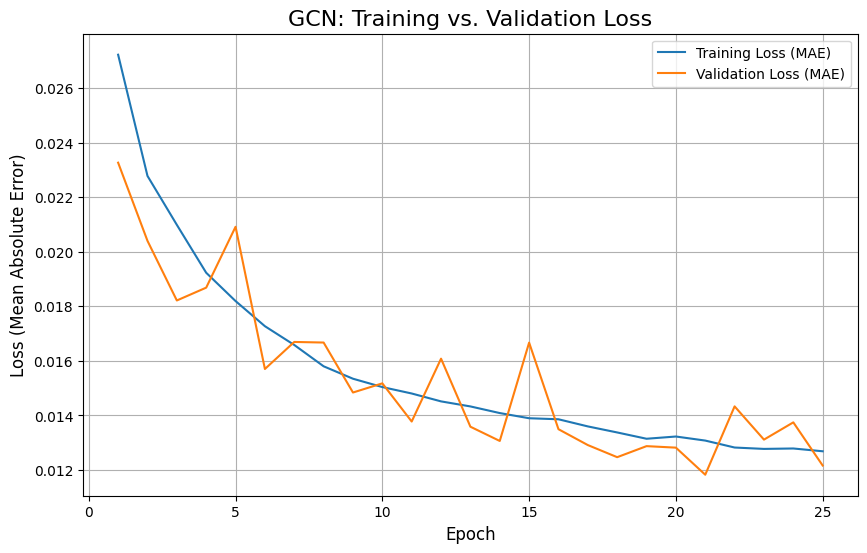

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Final Test MAE for GCN Model: 0.0123 au


In [6]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_smiles
from tqdm.notebook import tqdm
import numpy as np


print("Converting SMILES to graphs for GCN model...")
data_list = []
for index, row in tqdm(df_clean.iterrows(), total=df_clean.shape[0]):
    try:
        data = from_smiles(row['SMILES'])
        data.y = torch.tensor([[row[TARGET_PROPERTY]]], dtype=torch.float)
        data_list.append(data)
    except Exception as e:
        pass

print(f"Successfully converted {len(data_list)} molecules.")

# Create Train/Validation/Test Splits and DataLoaders
torch.manual_seed(42)
data_list = sorted(data_list, key=lambda x: torch.rand(1)) # Shuffle
train_size = int(0.8 * len(data_list))
val_size = int(0.1 * len(data_list))
test_size = len(data_list) - train_size - val_size

train_data = data_list[:train_size]
val_data = data_list[train_size:train_size + val_size]
test_data = data_list[train_size + val_size:]

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Use a standard batch size for this scalar regression task
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

class BaselineGCN(torch.nn.Module):
    def __init__(self, feature_size, model_dim):
        super().__init__()
        torch.manual_seed(42)
        # GCNConv is the classic, simpler graph convolution
        self.conv1 = GCNConv(feature_size, model_dim)
        self.conv2 = GCNConv(model_dim, model_dim)
        self.conv3 = GCNConv(model_dim, model_dim)

        # Readout layers
        self.linear1 = Linear(model_dim, 128)
        self.linear2 = Linear(128, 1) # Output is 1 value

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch


        x = x.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))


        x = global_mean_pool(x, batch)

        x = F.elu(self.linear1(x))
        x = self.linear2(x) # Final prediction
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"--- Using device: {device} ---")

model_dim = 64
feature_size = data_list[0].num_features

gcn_model = BaselineGCN(feature_size, model_dim).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001)
# We use L1Loss (Mean Absolute Error) as it's robust to outliers
loss_fn = torch.nn.L1Loss()

def train_gcn(model, loader):
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_gcn(model, loader):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating", leave=False):
            data = data.to(device)
            out = model(data)
            mae = loss_fn(out, data.y)
            total_mae += mae.item() * data.num_graphs
    return total_mae / len(loader.dataset)

import matplotlib.pyplot as plt

train_loss_history = []
val_loss_history = []


print("--- Starting GCN Model Training (Tracking Loss) ---")
num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train_loss = train_gcn(gcn_model, train_loader)
    val_mae = eval_gcn(gcn_model, val_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_mae)

    print(f'Epoch: {epoch:02d}, Train Loss (MAE): {train_loss:.4f}, Val MAE: {val_mae:.4f}')

print("\n--- GCN Model Training Complete ---")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss (MAE)')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss (MAE)')
plt.title('GCN: Training vs. Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Absolute Error)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
test_mae_gcn = eval_gcn(gcn_model, test_loader)
print(f'Final Test MAE for GCN Model: {test_mae_gcn:.4f} au')

Gathering predictions from the GCN model...


Getting Predictions:   0%|          | 0/205 [00:00<?, ?it/s]

Predictions and labels gathered. Ready for plotting.
GCN Model R-squared (R²): 0.8781


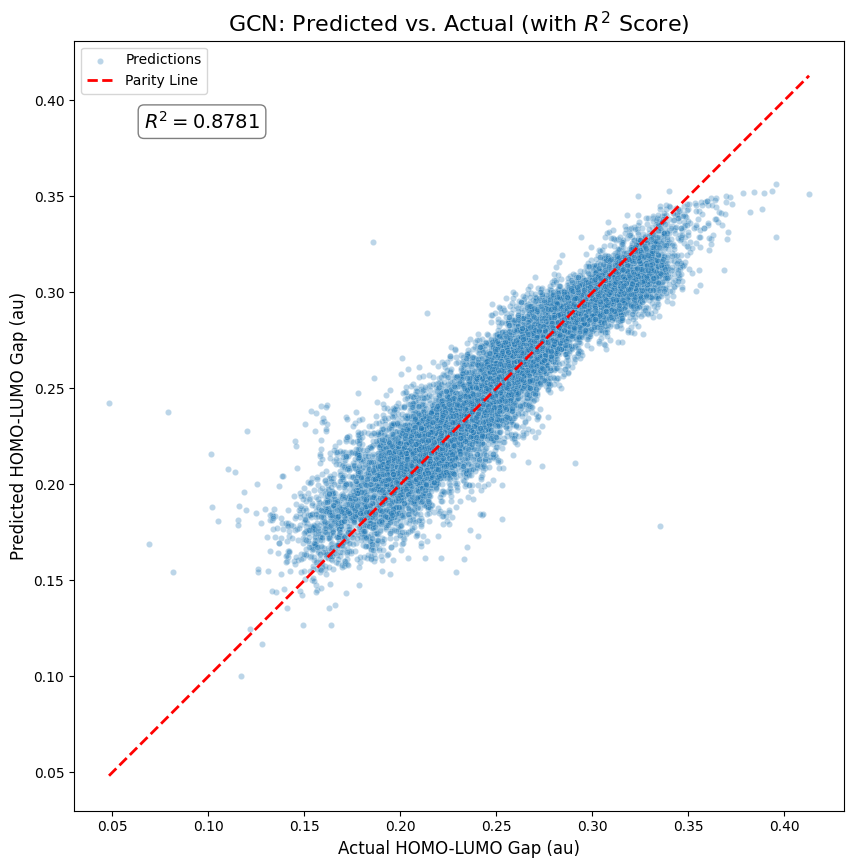

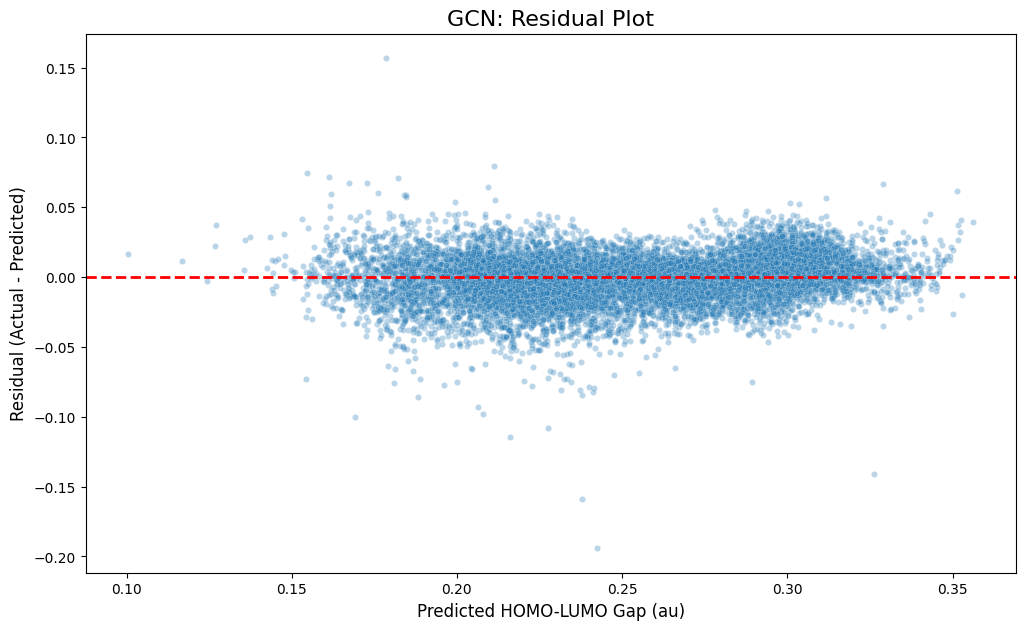

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

def get_predictions(model, loader):
    """Utility function to get predictions and labels from the test set."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Getting Predictions", leave=False):
            data = data.to(device)
            out = model(data)

            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    return all_preds, all_labels

print("Gathering predictions from the GCN model...")
y_pred_gcn, y_true = get_predictions(gcn_model, test_loader)

print("Predictions and labels gathered. Ready for plotting.")

r2_gcn = r2_score(y_true, y_pred_gcn)
print(f'GCN Model R-squared (R²): {r2_gcn:.4f}')

plt.figure(figsize=(10, 10))

sns.scatterplot(x=y_true, y=y_pred_gcn, alpha=0.3, s=20, label='Predictions')
min_val = min(y_true.min(), y_pred_gcn.min())
max_val = max(y_true.max(), y_pred_gcn.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Parity Line')

plt.text(min_val + (max_val - min_val) * 0.05,  # 5% from the left
         max_val - (max_val - min_val) * 0.05,  # 5% from the top
         f'$R^2 = {r2_gcn:.4f}$',
         fontsize=14,
         va='top', # Vertical alignment
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)) # Add a semi-transparent box

plt.title('GCN: Predicted vs. Actual (with $R^2$ Score)', fontsize=16)
plt.xlabel('Actual HOMO-LUMO Gap (au)', fontsize=12)
plt.ylabel('Predicted HOMO-LUMO Gap (au)', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()

residuals_gcn = y_true - y_pred_gcn

plt.figure(figsize=(12, 7))


sns.scatterplot(x=y_pred_gcn, y=residuals_gcn, alpha=0.3, s=20)

plt.axhline(y=0, color='red', linestyle='--', lw=2)

plt.title('GCN: Residual Plot', fontsize=16)
plt.xlabel('Predicted HOMO-LUMO Gap (au)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.show()

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATv2Conv, global_mean_pool
from tqdm.notebook import tqdm
import numpy as np


class BaselineGAT(torch.nn.Module):
    def __init__(self, feature_size, model_dim):
        super().__init__()
        torch.manual_seed(42)
        # GATv2 with 4 attention heads
        self.conv1 = GATv2Conv(feature_size, model_dim, heads=4)
        self.conv2 = GATv2Conv(model_dim * 4, model_dim, heads=4)
        self.conv3 = GATv2Conv(model_dim * 4, model_dim, heads=4)

        # Readout layers
        self.linear1 = Linear(model_dim * 4, 128)
        self.linear2 = Linear(128, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = x.float()
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = F.elu(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)

        x = F.elu(self.linear1(x))
        x = self.linear2(x)
        return x


model_dim = 64
feature_size = data_list[0].num_features

gat_model = BaselineGAT(feature_size, model_dim).to(device)
optimizer_gat = torch.optim.Adam(gat_model.parameters(), lr=0.001)
loss_fn_gat = torch.nn.L1Loss()

def train_gat(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in tqdm(loader, desc="Training", leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def eval_gat(model, loader, loss_fn):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for data in tqdm(loader, desc="Evaluating", leave=False):
            data = data.to(device)
            out = model(data)
            mae = loss_fn(out, data.y)
            total_mae += mae.item() * data.num_graphs
    return total_mae / len(loader.dataset)


print("--- Starting GATv2 Model Training (Advanced Baseline) ---")
num_epochs = 25

# Lists to store loss history for plotting
gat_train_loss_history = []
gat_val_loss_history = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_gat(gat_model, train_loader, optimizer_gat, loss_fn_gat)
    val_mae = eval_gat(gat_model, val_loader, loss_fn_gat)

    # Save history
    gat_train_loss_history.append(train_loss)
    gat_val_loss_history.append(val_mae)

    print(f'Epoch: {epoch:02d}, Train Loss (MAE): {train_loss:.4f}, Val MAE: {val_mae:.4f}')

print("\n--- GATv2 Model Training Complete ---")
test_mae_gat = eval_gat(gat_model, test_loader, loss_fn_gat)
print(f'Final Test MAE for GATv2 Model: {test_mae_gat:.4f} au')
try:
    print(f'Final Test MAE for GCN Model:  {test_mae_gcn:.4f} au')
except NameError:
    print("Run GCN model cell to see GCN MAE.")

--- Starting GATv2 Model Training (Advanced Baseline) ---


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 01, Train Loss (MAE): 0.0266, Val MAE: 0.0153


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 02, Train Loss (MAE): 0.0148, Val MAE: 0.0147


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 03, Train Loss (MAE): 0.0126, Val MAE: 0.0111


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 04, Train Loss (MAE): 0.0114, Val MAE: 0.0104


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 05, Train Loss (MAE): 0.0107, Val MAE: 0.0098


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 06, Train Loss (MAE): 0.0101, Val MAE: 0.0097


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 07, Train Loss (MAE): 0.0097, Val MAE: 0.0091


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 08, Train Loss (MAE): 0.0094, Val MAE: 0.0087


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 09, Train Loss (MAE): 0.0091, Val MAE: 0.0085


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 10, Train Loss (MAE): 0.0089, Val MAE: 0.0109


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 11, Train Loss (MAE): 0.0086, Val MAE: 0.0084


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 12, Train Loss (MAE): 0.0085, Val MAE: 0.0091


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 13, Train Loss (MAE): 0.0084, Val MAE: 0.0086


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 14, Train Loss (MAE): 0.0082, Val MAE: 0.0076


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 15, Train Loss (MAE): 0.0082, Val MAE: 0.0075


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 16, Train Loss (MAE): 0.0080, Val MAE: 0.0092


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 17, Train Loss (MAE): 0.0080, Val MAE: 0.0076


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 18, Train Loss (MAE): 0.0079, Val MAE: 0.0076


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 19, Train Loss (MAE): 0.0078, Val MAE: 0.0082


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 20, Train Loss (MAE): 0.0077, Val MAE: 0.0085


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 21, Train Loss (MAE): 0.0076, Val MAE: 0.0080


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 22, Train Loss (MAE): 0.0076, Val MAE: 0.0078


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 23, Train Loss (MAE): 0.0075, Val MAE: 0.0078


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 24, Train Loss (MAE): 0.0075, Val MAE: 0.0072


Training:   0%|          | 0/1636 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch: 25, Train Loss (MAE): 0.0074, Val MAE: 0.0076

--- GATv2 Model Training Complete ---


Evaluating:   0%|          | 0/205 [00:00<?, ?it/s]

Final Test MAE for GATv2 Model: 0.0076 au
Final Test MAE for GCN Model:  0.0123 au


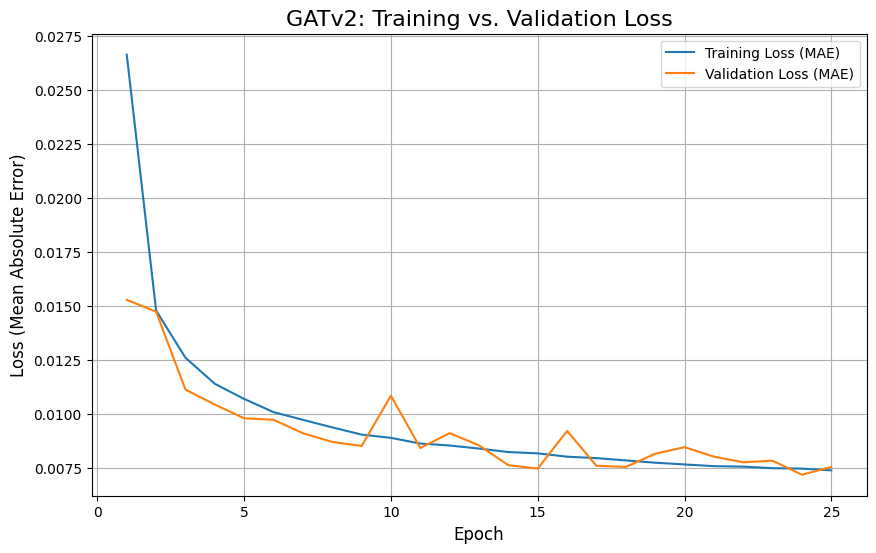

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), gat_train_loss_history, label='Training Loss (MAE)')
plt.plot(range(1, num_epochs + 1), gat_val_loss_history, label='Validation Loss (MAE)')
plt.title('GATv2: Training vs. Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Absolute Error)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Gathering predictions from the GATv2 model...


Getting Predictions:   0%|          | 0/205 [00:00<?, ?it/s]

GATv2 Model R-squared (R²): 0.9517


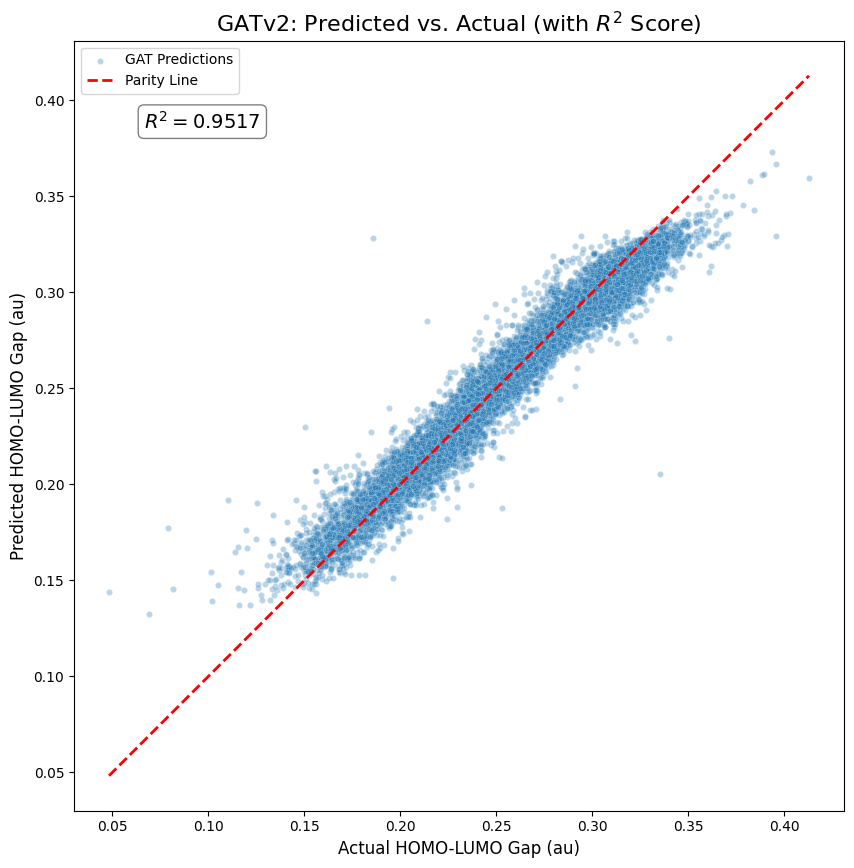

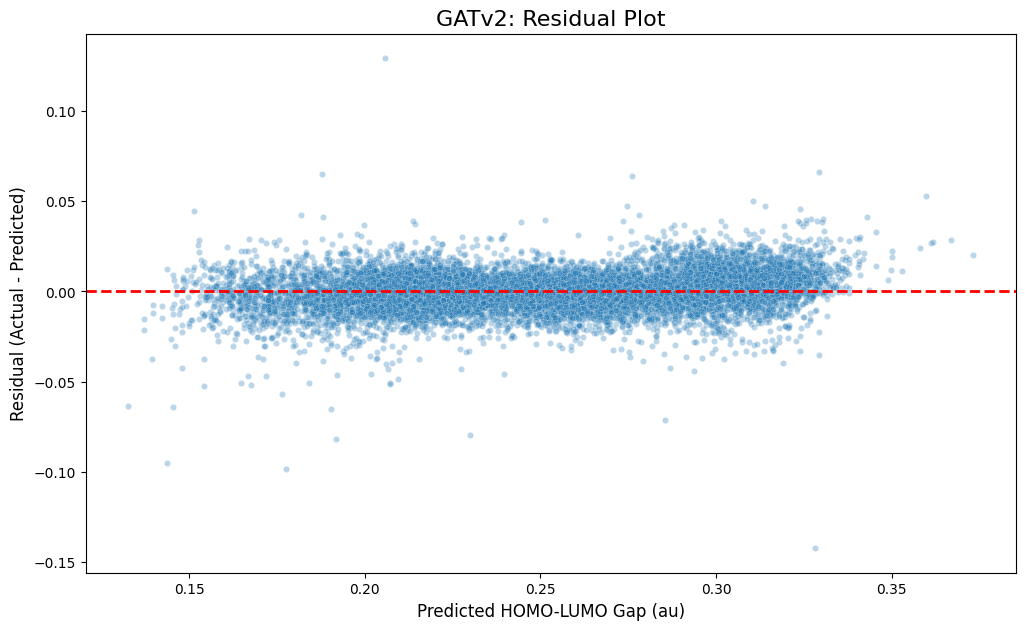

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in tqdm(loader, desc="Getting Predictions", leave=False):
            data = data.to(device)
            out = model(data)
            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    return all_preds, all_labels


print("Gathering predictions from the GATv2 model...")
y_pred_gat, y_true_gat = get_predictions(gat_model, test_loader)


r2_gat = r2_score(y_true_gat, y_pred_gat)
print(f'GATv2 Model R-squared (R²): {r2_gat:.4f}')


plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_true_gat, y=y_pred_gat, alpha=0.3, s=20, label='GAT Predictions')

min_val = min(y_true_gat.min(), y_pred_gat.min())
max_val = max(y_true_gat.max(), y_pred_gat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Parity Line')

plt.text(min_val + (max_val - min_val) * 0.05,
         max_val - (max_val - min_val) * 0.05,
         f'$R^2 = {r2_gat:.4f}$',
         fontsize=14, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.title('GATv2: Predicted vs. Actual (with $R^2$ Score)', fontsize=16)
plt.xlabel('Actual HOMO-LUMO Gap (au)', fontsize=12)
plt.ylabel('Predicted HOMO-LUMO Gap (au)', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


residuals_gat = y_true_gat - y_pred_gat
plt.figure(figsize=(12, 7))
sns.scatterplot(x=y_pred_gat, y=residuals_gat, alpha=0.3, s=20)
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('GATv2: Residual Plot', fontsize=16)
plt.xlabel('Predicted HOMO-LUMO Gap (au)', fontsize=12)
plt.ylabel('Residual (Actual - Predicted)', fontsize=12)
plt.show()

In [12]:
# Re-create data_list, this time adding the .smiles attribute
print("Re-processing data to include SMILES strings for analysis...")

data_list_with_smiles = []
for index, row in tqdm(df_clean.iterrows(), total=df_clean.shape[0]):
    try:
        data = from_smiles(row['SMILES'])
        data.y = torch.tensor([[row[TARGET_PROPERTY]]], dtype=torch.float)
        data.smiles = row['SMILES']
        data_list_with_smiles.append(data)
    except Exception as e:
        pass

# We use the same seed to ensure the shuffle is identical to before
torch.manual_seed(42)
data_list_shuffled = sorted(data_list_with_smiles, key=lambda x: torch.rand(1))

train_size = int(0.8 * len(data_list_shuffled))
val_size = int(0.1 * len(data_list_shuffled))
test_size = len(data_list_shuffled) - train_size - val_size

analysis_test_data = data_list_shuffled[train_size + val_size:]

analysis_test_loader = DataLoader(analysis_test_data, batch_size=64, shuffle=False)

print(f"Created new test loader with {len(analysis_test_data)} molecules.")

Re-processing data to include SMILES strings for analysis...


  0%|          | 0/130831 [00:00<?, ?it/s]

Created new test loader with 13084 molecules.


/tmp/ipython-input-1471065241.py:24: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  analysis_test_loader = DataLoader(analysis_test_data, batch_size=64, shuffle=False)


In [ ]:
import pandas as pd
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem


def get_predictions_with_details(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_smiles = []

    with torch.no_grad():
        for data in tqdm(loader, desc="Getting Predictions", leave=False):
            data = data.to(device)
            out = model(data)

            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())
            # We can access the .smiles attribute from the batch
            all_smiles.extend(data.smiles)

    all_preds = np.concatenate(all_preds).flatten()
    all_labels = np.concatenate(all_labels).flatten()
    return all_preds, all_labels, all_smiles


y_pred, y_true, smiles = get_predictions_with_details(gat_model, analysis_test_loader)


error_df = pd.DataFrame({
    'SMILES': smiles,
    'Actual_Gap': y_true,
    'Predicted_Gap': y_pred
})
error_df['Absolute_Error'] = (error_df['Actual_Gap'] - error_df['Predicted_Gap']).abs()


error_df_sorted = error_df.sort_values(by='Absolute_Error', ascending=False)

print("--- GATv2 Model Failure Analysis ---")
display(error_df_sorted.head(10))

print("--- Visualizing Top 10 Worst Predictions ---")
for index, row in error_df_sorted.head(10).iterrows():
    print(f"--- Molecule Rank #{index + 1} ---")
    print(f"SMILES: {row['SMILES']}")
    print(f"Actual Gap: {row['Actual_Gap']:.4f} au")
    print(f"Predicted Gap: {row['Predicted_Gap']:.4f} au")
    print(f"Absolute Error: {row['Absolute_Error']:.4f} au")

    # Generate 3D model
    mol = Chem.MolFromSmiles(row['SMILES'])
    mol = Chem.AddHs(mol)


    embed_code = AllChem.EmbedMolecule(mol, AllChem.ETKDG())

    if embed_code == 0:
        try:

            AllChem.MMFFOptimizeMolecule(mol)

            mblock = Chem.MolToMolBlock(mol)

            view = py3Dmol.view(width=500, height=400)
            view.addModel(mblock, 'mol')
            view.setStyle({'stick':{}, 'sphere': {'scale':0.3}})
            view.zoomTo()
            view.show()

        except ValueError as e:
            print(f"  -> WARNING: MMFFOptimize failed: {e}")
            print("  -> Skipping 3D visualization for this molecule.")
    else:
        # If embed_code was -1 (failure)
        print(f"  -> WARNING: RDKit's EmbedMolecule failed to generate 3D conformer.")
        print("  -> Skipping 3D visualization for this molecule.")

    print("-" * 20) # Separator